# Analysis of Experiment 1a

## 读取数据文件

In [ ]:
# 设置目标文件夹相对路径
folder_path <- "../2_Experiments/2_1_Pilot_Experiment/2_2_2_RawData/RawData"

# 列出所有含有"Exp1A_"的csv文件
file_list <- list.files(
  path = folder_path,
  pattern = "*Exp1A_.*\\.csv$", full.names = TRUE
)

# 创建一个空列表来存储数据
df_list_1 <- list()

# 逐个读取文件并存储
for (file in file_list) {
  file_name <- tools::file_path_sans_ext(basename(file))  # 获取文件名（不带扩展名）
  df_list_1[[file_name]] <- read.csv(file)  # 将数据存储在列表中
}
rm(file, file_list, folder_path)

## 数据清洗 

In [ ]:
# 创建输出文件夹（如果不存在）
output_path <- "../2_Experiments/2_1_Pilot_Experiment/2_3_3_ClenaData/Expt_1a"
if (!dir.exists(output_path)) {
  dir.create(output_path, recursive = TRUE)
}

# 逐篇处理每个数据框
for (file_name in names(df_list_1)) {
  data <- df_list_1[[file_name]]

  # 提取被试信息
  participant_info <- data[data$part == "survey", "response"]
  participant_info <- gsub("[{}\"]", "", participant_info) # 去掉多余的字符
  info_list <- strsplit(participant_info, ",")[[1]]

  # 创建新的变量
  participant_data <- data.frame(
    Participant_ID = file_name,
    Sex = as.character(NA),
    Age = as.numeric(NA),
    Handedness = as.character(NA),
    Color_blindness = as.character(NA),
    stringsAsFactors = FALSE
  )

  for (info in info_list) {
    key_value <- strsplit(info, ":")[[1]]
    key <- trimws(key_value[1])
    value <- trimws(key_value[2])
    if (key == "sex") participant_data$Sex <- value
    if (key == "age") participant_data$Age <- as.numeric(value)
    if (key == "hands") participant_data$Handedness <- value
    if (key == "color_blindness") participant_data$Color_blindness <- value
  }

  # 提取行为数据
  behavior_data <- data[
    data$part %in% c("match_RDK", "RDK"),
    c(
      "part", "rt", "response", "correct",
      "match", "association", "difficulty"
    )
  ]
  # 将 correct 列转换为逻辑型
  behavior_data$correct <- as.logical(behavior_data$correct)

  # 然后再转换为 0 和 1
  behavior_data$correct <- as.integer(behavior_data$correct)

  # 分别提取正式试次
  official_trials <- do.call(
    rbind,
    lapply(unique(behavior_data$part), function(part) {
      part_data <- behavior_data[behavior_data$part == part, ]
      tail(part_data, 120) # 取最后120个试次
    })
  )

  # 合并被试信息和行为数据
  final_data <- cbind(participant_data, official_trials)

  # 输出到新的CSV文件
  output_file <- file.path(output_path, paste0(file_name, "_Clean.csv"))
  write.csv(final_data, output_file, row.names = FALSE)
}


## 读取清洗后的数据 

In [ ]:
# 设置目标文件夹相对路径
folder_path <- "../2_Experiments/2_1_Pilot_Experiment/2_3_3_ClenaData/Expt_1a"

# 列出所有含有"Exp1A_"的csv文件
file_list <- list.files(
  path = folder_path,
  pattern = "*Exp1A_.*\\.csv$", full.names = TRUE
)

# 创建一个空列表来存储数据
df_list_1 <- list()

# 逐个读取文件并存储
for (file in file_list) {
  file_name <- tools::file_path_sans_ext(basename(file)) # 获取文件名（不带扩展名）
  df_list_1[[file_name]] <- read.csv(file) # 将数据存储在列表中
}
rm(file, file_list, file_name, folder_path)

## 分析思路
1. 分 motion 和 color
2. 对不同任务下的反应时进行重复测量方差分析
  - 匹配任务
     - 自我 vs. 他人
     - 匹配 vs. 不匹配
  - rdk 判断任务
     - 自我 vs. 他人
     - 容易 vs. 困难
3. 对正确率采用信号检测论的方法

In [ ]:
## 对反应时的分析

# 画图
## Motion

In [ ]:
library(ggplot2)
library(dplyr)
library(ggokabeito)
library(cowplot)

# 假设 df_list_1 是您提供的列表
data <- do.call(rbind, df_list_1)

# 选择实验组，例如，选择第一个实验组

# Motion
data <- data %>%
  filter(Participant_ID %in% c(paste0("Exp1A_", seq(1, 10))))

# 计算 match_RDK 的平均 RT 和标准误，按 match 分类
summary_data_match_rt <- data %>%
  filter(part == "match_RDK") %>%
  group_by(association, match) %>%
  summarise(
    mean_rt = mean(rt, na.rm = TRUE),
    se_rt = sd(rt, na.rm = TRUE) / sqrt(n()),
    .groups = "drop"
  )

# 计算 match_RDK 的正确率，按 match 分类
summary_data_match_acc <- data %>%
  filter(part == "match_RDK") %>%
  group_by(association, match) %>%
  summarise(
    mean_correct = mean(correct, na.rm = TRUE),
    se_correct = sd(correct, na.rm = TRUE) / sqrt(n()),
    .groups = "drop"
  )

# 计算 RDK 的平均 RT 和标准误，按 difficulty 分类
summary_data_RDK_rt <- data %>% # nolint
  filter(part == "RDK") %>%
  group_by(association, difficulty) %>%
  summarise(
    mean_rt = mean(rt, na.rm = TRUE),
    se_rt = sd(rt, na.rm = TRUE) / sqrt(n()),
    .groups = "drop"
  )

# 计算 RDK 的正确率，按 difficulty 分类
summary_data_RDK_acc <- data %>% # nolint: object_name_linter.
  filter(part == "RDK") %>%
  group_by(association, difficulty) %>%
  summarise(
    mean_correct = mean(correct, na.rm = TRUE),
    se_correct = sd(correct, na.rm = TRUE) / sqrt(n()),
    .groups = "drop"
  )

# 设置颜色主题
cbp <- ggokabeito::scale_okabe_ito(
  aesthetics = c("color", "fill", "edge_colour"),
  order = c(1, 2, 7, 3:6)
)


# 绘制 match_RDK 的 RT 条形图，按 association 分类
p1 <- ggplot(
  summary_data_match_rt,
  aes(x = match, y = mean_rt, fill = association)
) +
  geom_col(
    color = "black", width = 0.35,
    position = position_dodge(width = 0.4)
  ) + # 缩小距离
  geom_errorbar(aes(ymin = mean_rt - se_rt, ymax = mean_rt + se_rt),
    width = 0.2, position = position_dodge(width = 0.4)
  ) + # 缩小距离
  labs(x = "Identity", y = "Reaction Times (ms)", title = "Task 1: Match RDK") +
  coord_cartesian(ylim = c(
    0,
    max(summary_data_match_rt$mean_rt +
          summary_data_match_rt$se_rt, na.rm = TRUE)
  )) +
  cbp +
  theme_minimal() +
  theme(
    legend.position = "top",
    plot.title = element_text(hjust = 0.5, size = 14, face = "bold"),
    axis.title.y = element_text(size = 12, face = "bold"),
    axis.title.x = element_text(size = 12, face = "bold")
  )

# 绘制 match_RDK 的 ACC 条形图，按 association 分类
p2 <- ggplot(
  summary_data_match_acc,
  aes(x = match, y = mean_correct, fill = association)
) +
  geom_col(
    color = "black", width = 0.35,
    position = position_dodge(width = 0.4)
  ) + # 缩小距离
  geom_errorbar(
    aes(
      ymin = mean_correct - se_correct,
      ymax = mean_correct + se_correct
    ),
    width = 0.2, position = position_dodge(width = 0.4)
  ) + # 缩小距离
  labs(x = "Identity", y = "Accuracy", title = "Task 1: Match RDK") +
  coord_cartesian(ylim = c(0.8, 1)) +
  cbp +
  theme_minimal() +
  # coord_cartesian(ylim = c(0.8, 1)) + (这里重复了可以去掉)
  theme(
    legend.position = "top",
    plot.title = element_text(hjust = 0.5, size = 14, face = "bold"),
    axis.title.y = element_text(size = 12, face = "bold"),
    axis.title.x = element_text(size = 12, face = "bold")
  )

# 绘制 RDK 的 RT 条形图，按 association 分类
p3 <- ggplot(
  summary_data_RDK_rt,
  aes(x = difficulty, y = mean_rt, fill = association)
) +
  geom_col(
    color = "black",
    width = 0.35, position = position_dodge(width = 0.4)
  ) + # 缩小距离
  geom_errorbar(aes(ymin = mean_rt - se_rt, ymax = mean_rt + se_rt),
    width = 0.2, position = position_dodge(width = 0.4)
  ) + # 缩小距离
  labs(x = "Identity", y = "Reaction Times (ms)", title = "Task 2: RDK") +
  coord_cartesian(ylim = c(0, max(summary_data_RDK_rt$mean_rt +
    summary_data_RDK_rt$se_rt, na.rm = TRUE))) +
  cbp +
  theme_minimal() +
  theme(
    legend.position = "top",
    plot.title = element_text(hjust = 0.5, size = 14, face = "bold"),
    axis.title.y = element_text(size = 12, face = "bold"),
    axis.title.x = element_text(size = 12, face = "bold")
  )

# 绘制 RDK 的 ACC 条形图，按 association 分类
p4 <- ggplot(
  summary_data_RDK_acc,
  aes(x = difficulty, y = mean_correct, fill = association)
) +
  geom_col(
    color = "black", width = 0.35,
    position = position_dodge(width = 0.4)
  ) + # 缩小距离
  geom_errorbar(
    aes(
      ymin = mean_correct - se_correct,
      ymax = mean_correct + se_correct
    ),
    width = 0.2, position = position_dodge(width = 0.4)
  ) + # 缩小距离
  labs(x = "Identity", y = "Accuracy", title = "Task 2: RDK") +
  coord_cartesian(ylim = c(0.6, 1)) +
  cbp +
  theme_minimal() +
  # coord_cartesian(ylim = c(0.6, 1)) + (这里重复了可以去掉)
  theme(
    legend.position = "top",
    plot.title = element_text(hjust = 0.5, size = 14, face = "bold"),
    axis.title.y = element_text(size = 12, face = "bold"),
    axis.title.x = element_text(size = 12, face = "bold")
  )

# 合并四个图形
combined_plot <- plot_grid(p1, p2, p3, p4, align = "hv", ncol = 2)
print(combined_plot)


geom_flat_violin(
      position = position_nudge(x = .25, y = 0),
      adjust = 2, trim = FALSE, alpha = 0.5
      ) +

## Color


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




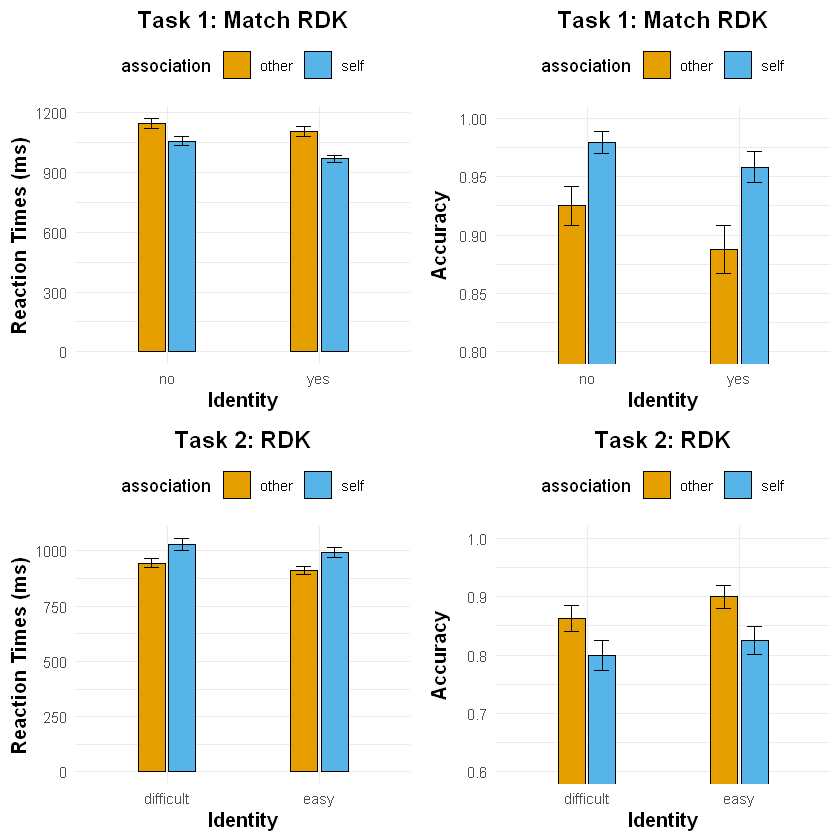

In [ ]:
library(ggplot2)
library(dplyr)
library(ggokabeito)
library(cowplot)

# 假设 df_list_1 是您提供的列表
data <- do.call(rbind, df_list_1)

# 选择实验组，例如，选择第一个实验组

## Color
data <- data %>%
    filter(Participant_ID %in% c(paste0("Exp1A_", seq(18, 25))))

# 计算 match_RDK 的平均 RT 和标准误，按 match 分类
summary_data_match_rt <- data %>%
    filter(part == "match_RDK") %>%
    group_by(association, match) %>%
    summarise(
        mean_rt = mean(rt, na.rm = TRUE),
        se_rt = sd(rt, na.rm = TRUE) / sqrt(n()),
        .groups = "drop"
    )

# 计算 match_RDK 的正确率，按 match 分类
summary_data_match_acc <- data %>%
    filter(part == "match_RDK") %>%
    group_by(association, match) %>%
    summarise(
        mean_correct = mean(correct, na.rm = TRUE),
        se_correct = sd(correct, na.rm = TRUE) / sqrt(n()),
        .groups = "drop"
    )

# 计算 RDK 的平均 RT 和标准误，按 difficulty 分类
summary_data_RDK_rt <- data %>%
    filter(part == "RDK") %>%
    group_by(association, difficulty) %>%
    summarise(
        mean_rt = mean(rt, na.rm = TRUE),
        se_rt = sd(rt, na.rm = TRUE) / sqrt(n()),
        .groups = "drop"
    )

# 计算 RDK 的正确率，按 difficulty 分类
summary_data_RDK_acc <- data %>%
    filter(part == "RDK") %>%
    group_by(association, difficulty) %>%
    summarise(
        mean_correct = mean(correct, na.rm = TRUE),
        se_correct = sd(correct, na.rm = TRUE) / sqrt(n()),
        .groups = "drop"
    )

# 设置颜色主题
cbp <- ggokabeito::scale_okabe_ito(
    aesthetics = c("color", "fill", "edge_colour"),
    order = c(1, 2, 7, 3:6)
)


# 绘制 match_RDK 的 RT 条形图，按 association 分类
p1 <- ggplot(
    summary_data_match_rt,
    aes(x = match, y = mean_rt, fill = association)
) +
    geom_col(
        color = "black", width = 0.35,
        position = position_dodge(width = 0.4)
    ) + # 缩小距离
    geom_errorbar(aes(ymin = mean_rt - se_rt, ymax = mean_rt + se_rt),
        width = 0.2, position = position_dodge(width = 0.4)
    ) + # 缩小距离
    labs(
        x = "Identity", y = "Reaction Times (ms)",
        title = "Task 1: Match RDK"
    ) +
    coord_cartesian(
        ylim = c(0, max(
            summary_data_match_rt$mean_rt +
                summary_data_match_rt$se_rt,
            na.rm = TRUE
        ))
    ) +
    cbp +
    theme_minimal() +
    theme(
        legend.position = "top",
        plot.title = element_text(hjust = 0.5, size = 14, face = "bold"),
        axis.title.y = element_text(size = 12, face = "bold"),
        axis.title.x = element_text(size = 12, face = "bold")
    )

# 绘制 match_RDK 的 ACC 条形图，按 association 分类
p2 <- ggplot(
    summary_data_match_acc,
    aes(x = match, y = mean_correct, fill = association)
) +
    geom_col(
        color = "black", width = 0.35,
        position = position_dodge(width = 0.4)
    ) + # 缩小距离
    geom_errorbar(
        aes(
            ymin = mean_correct - se_correct,
            ymax = mean_correct + se_correct
        ),
        width = 0.2, position = position_dodge(width = 0.4)
    ) + # 缩小距离
    labs(x = "Identity", y = "Accuracy", title = "Task 1: Match RDK") +
    coord_cartesian(ylim = c(0.8, 1)) +
    cbp +
    theme_minimal() +
    # coord_cartesian(ylim = c(0.8, 1)) +   (这里重复了可以去掉)
    theme(
        legend.position = "top",
        plot.title = element_text(hjust = 0.5, size = 14, face = "bold"),
        axis.title.y = element_text(size = 12, face = "bold"),
        axis.title.x = element_text(size = 12, face = "bold")
    )

# 绘制 RDK 的 RT 条形图，按 association 分类
p3 <- ggplot(
    summary_data_RDK_rt,
    aes(x = difficulty, y = mean_rt, fill = association)
) +
    geom_col(
        color = "black", width = 0.35,
        position = position_dodge(width = 0.4)
    ) + # 缩小距离
    geom_errorbar(aes(ymin = mean_rt - se_rt, ymax = mean_rt + se_rt),
        width = 0.2, position = position_dodge(width = 0.4)
    ) + # 缩小距离
    labs(x = "Identity", y = "Reaction Times (ms)", title = "Task 2: RDK") +
    coord_cartesian(ylim = c(0, max(summary_data_RDK_rt$mean_rt +
        summary_data_RDK_rt$se_rt, na.rm = TRUE))) +
    cbp +
    theme_minimal() +
    theme(
        legend.position = "top",
        plot.title = element_text(hjust = 0.5, size = 14, face = "bold"),
        axis.title.y = element_text(size = 12, face = "bold"),
        axis.title.x = element_text(size = 12, face = "bold")
    )

# 绘制 RDK 的 ACC 条形图，按 association 分类
p4 <- ggplot(
    summary_data_RDK_acc,
    aes(x = difficulty, y = mean_correct, fill = association)
) +
    geom_col(
        color = "black", width = 0.35,
        position = position_dodge(width = 0.4)
    ) + # 缩小距离
    geom_errorbar(
        aes(
            ymin = mean_correct - se_correct,
            ymax = mean_correct + se_correct
        ),
        width = 0.2, position = position_dodge(width = 0.4)
    ) + # 缩小距离
    labs(x = "Identity", y = "Accuracy", title = "Task 2: RDK") +
    coord_cartesian(ylim = c(0.6, 1)) +
    cbp +
    theme_minimal() +
    # coord_cartesian(ylim = c(0.6, 1)) +   (这里重复了，可以去掉)
    theme(
        legend.position = "top",
        plot.title = element_text(hjust = 0.5, size = 14, face = "bold"),
        axis.title.y = element_text(size = 12, face = "bold"),
        axis.title.x = element_text(size = 12, face = "bold")
    )

# 合并四个图形
combined_plot <- plot_grid(p1, p2, p3, p4, align = "hv", ncol = 2)
print(combined_plot)

# 清理环境
# rm(cbp, combined_plot, p1, p2, p3, p4, summary_data_match_rt,
# summary_data_match_acc, summary_data_RDK_rt, summary_data_RDK_acc)
